#Credit Card Fraud Detection


## Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


## Load the Dataset

In [ ]:
df = pd.read_csv("creditcard 2.csv")


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Shape of Data

In [ ]:
df.shape

(284807, 31)

## Check for NULL Values


In [ ]:
df.isnull().values.any()

np.False_

## Checking number of records of each kind of transcation class (Fraud and Non- Fraud)

/tmp/ipython-input-41-2985153648.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


Text(0, 0.5, 'Frequency')

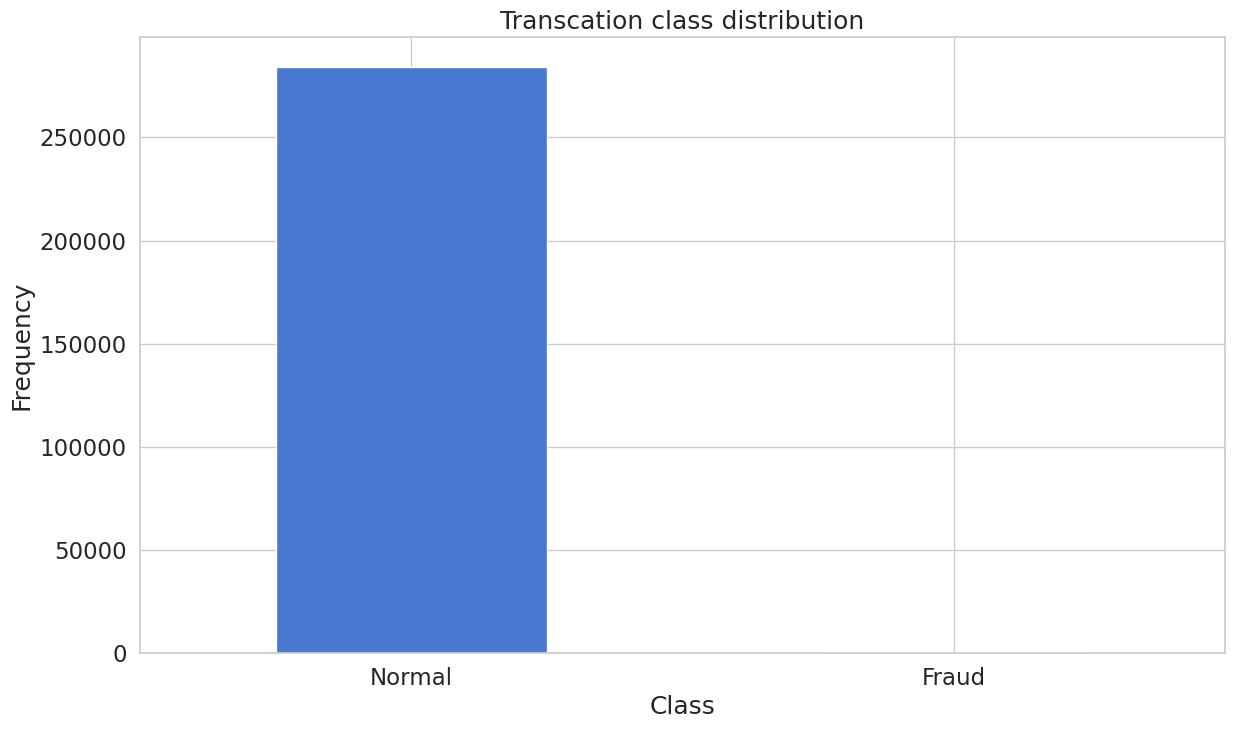

In [ ]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Transcation class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [ ]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [ ]:
normal.shape

(284315, 31)

## Checking the amount of money involved in each kind of transaction


### Fraud Transaction

In [ ]:
frauds.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


### Non-fraud Transactions

In [ ]:
normal.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


### Graphical Representation of Amount


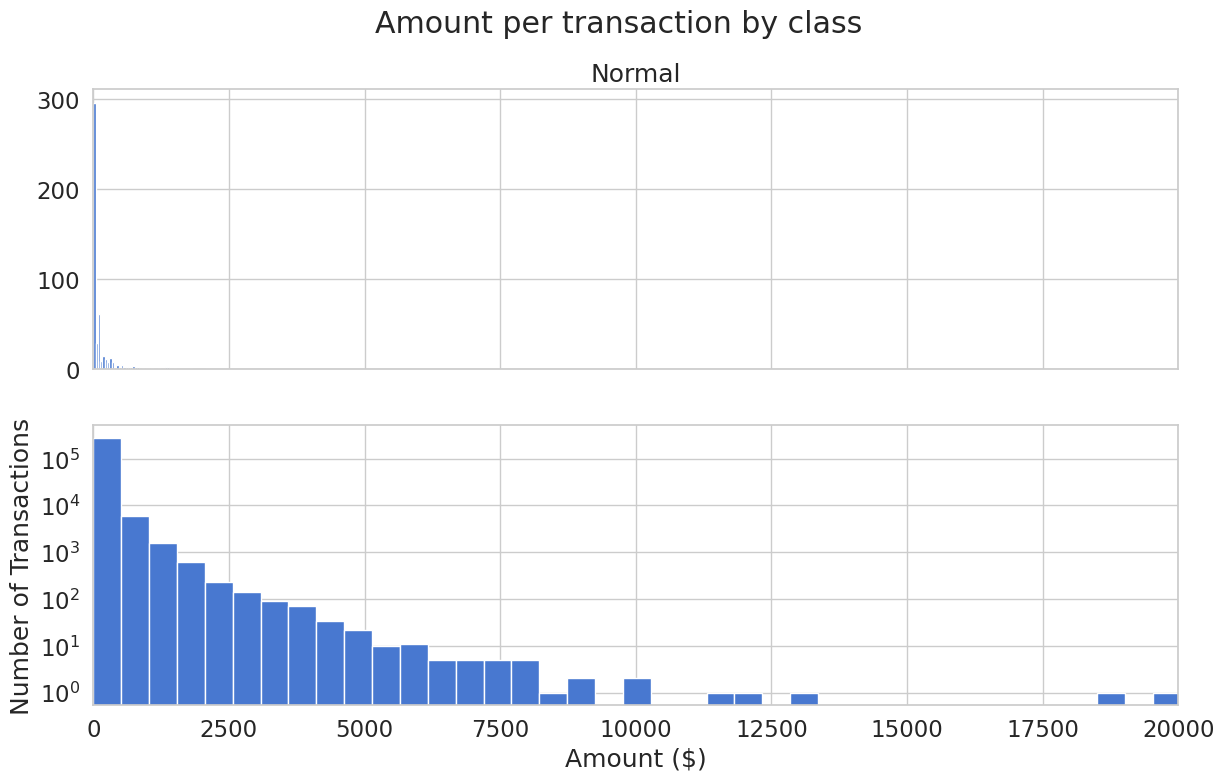

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1,sharex = True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax1.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim(0,20000)
plt.yscale('log')
plt.show()

## Plotting Time of Transaction to Check for Correlations

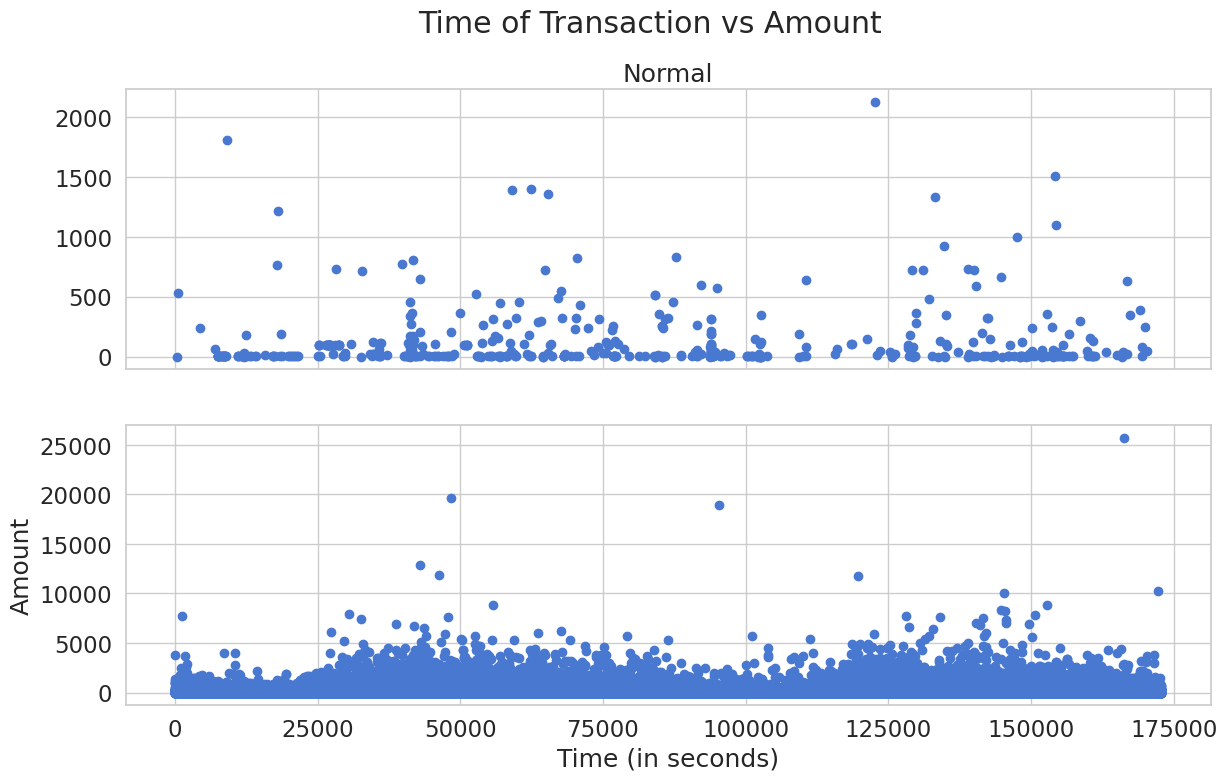

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1,sharex = True)
f.suptitle('Time of Transaction vs Amount')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax1.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

### Time does not seem to be a crucial feature in distinguishing normal vs fraud transactions. Hence drop it

In [ ]:
data = df.drop(['Time'], axis = 1)

## Scaling the amount using Standard Scalar

### Numerical amounts in fraud and normal cases differ highly. Hence scale Then

In [ ]:
from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the Model

### Using autoencoders train the model to learn the representation of non- fraudulent. To let the model learn the best representation of non fraudulent cases. So that it automatically distinguishes the other case.

In [ ]:
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Combine and shuffle
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

# Separate features and target
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values


## Split data into Train and Test

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis =1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis =1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

## Autoencoder model

In [ ]:
input_layer = Input(shape = (X.shape[1],))
#encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='tanh')(encoded)
#decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
#output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

## Training the Model

In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer = 'adadelta', loss = 'mse')

## Scaling the Values

In [ ]:
x = data.drop(['Class'], axis = 1)
y = data['Class'].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y==0], x_scale[y==1]

autoencoder.fit(x_norm[0:20000], x_norm[0:20000], batch_size = 256, epochs = 10, shuffle = True, validation_split = 0.2);


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9642 - val_loss: 0.9378
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9581 - val_loss: 0.9318
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9521 - val_loss: 0.9257
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9460 - val_loss: 0.9194
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9397 - val_loss: 0.9131
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9333 - val_loss: 0.9067
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9267 - val_loss: 0.9002
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9200 - val_loss: 0.8933
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9127 - val_loss: 0.8858
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9050 - val_loss: 0.8782


## Obtain the hidden representation

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [ ]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## Getting the Representation Data

In [ ]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

## Train, Test, Split

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)

## Prediction


In [ ]:
clf = LogisticRegression(solver='lbfgs').fit(train_x, train_y)
pred_y = clf.predict(val_x)
print("")
print("Classification Report: ")
print(classification_report(val_y, pred_y))

print("")
print("Accuracy Score: ", accuracy_score(val_y,pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       748
         1.0       1.00      0.66      0.79       125

    accuracy                           0.95       873
   macro avg       0.97      0.83      0.88       873
weighted avg       0.95      0.95      0.95       873


Accuracy Score:  0.9507445589919816
